In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 629.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
!pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 13.8 MB/s eta 0:00:00


# Necessary Suspects

In [ ]:
import os
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate
    )
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
import pandas as pd
import json
import matplotlib.pyplot as plt

In [ ]:
from getpass import getpass

# Prompt the user to enter the OpenAI API key securely
api_key = getpass('Enter your OpenAI API key: ')

# Set the API key in the environment
os.environ['OPENAI_API_KEY'] = api_key


Enter your OpenAI API key: ··········


In [ ]:
# Initialize the model with the OpenAI API key
model = ChatOpenAI(openai_api_key=api_key, temperature=0)

In [ ]:
# Define the output data model for destinations
class Destinations(BaseModel):
    values: list = Field(description='List of dictionaries with destination name, description, category, and average rating')
    most_popular_category: str = Field(description='Most popular category of destinations across the results')

# Initialize the Pydantic output parser once
parser = PydanticOutputParser(pydantic_object=Destinations)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"values": {"description": "List of dictionaries with destination name, description, category, and average rating", "items": {}, "title": "Values", "type": "array"}, "most_popular_category": {"description": "Most popular category of destinations across the results", "title": "Most Popular Category", "type": "string"}}, "required": ["values", "most_popular_category"]}
```


In [ ]:
# Define the prompt for gathering destination information
human_prompt = HumanMessagePromptTemplate.from_template("{request}\n{format_instructions}")
chat_prompt = ChatPromptTemplate.from_messages([human_prompt])

def fetch_data(query: str):
    # Set up the request with the provided query
    request = chat_prompt.format_messages(
        request=query,
        format_instructions=parser.get_format_instructions()
    )

    # Get results from the model
    results = model.invoke(request)

    # Clean the output to ensure valid JSON (remove comments or non-JSON text)
    cleaned_result = results.content.split("//")[0].strip()  # Remove anything after '//'

    try:
        # Parse the cleaned JSON response
        results_values = parser.parse(cleaned_result)  # Parse as Destinations class object
        return results_values
    except json.JSONDecodeError as e:
        print("Invalid JSON output:", cleaned_result)
        return None
    except Exception as e:
        print(f"Parsing error: {e}")
        return None

# Define your query
query = 'Give me facts about 100 tourist destinations across Japan, including their name, description, category, and average rating. Respond in valid JSON format.'

# Fetch data using the query
results_values = fetch_data(query)

if results_values:
    # Print the details of the Destinations object
    print(f"Values: {results_values.values}")
    if results_values.most_popular_category:
        print(f"Most Popular Category: {results_values.most_popular_category}")
    else:
        print("Most Popular Category is not available.")

    # Print the first few destinations
    for dest in results_values.values[:5]:  # Print the first 5 destinations for brevity
        print(dest)
else:
    print("Failed to parse valid destination data.")


Values: [{'name': 'Tokyo Tower', 'description': 'Iconic red and white tower offering panoramic views of Tokyo from its observation decks.', 'category': 'Landmark', 'average_rating': 4.5}, {'name': 'Hiroshima Peace Memorial Park', 'description': 'Park commemorating the victims of the atomic bomb with museums, monuments, and memorials.', 'category': 'Historical', 'average_rating': 4.7}, {'name': 'Mount Fuji', 'description': "Japan's highest mountain and a UNESCO World Heritage Site known for its symmetrical cone shape.", 'category': 'Natural', 'average_rating': 4.8}, {'name': 'Kyoto Imperial Palace', 'description': 'Former ruling palace of the Emperor of Japan with beautiful gardens and historic buildings.', 'category': 'Cultural', 'average_rating': 4.6}, {'name': 'Osaka Castle', 'description': 'Reconstructed castle with a museum showcasing the history of Osaka and its feudal past.', 'category': 'Landmark', 'average_rating': 4.4}, {'name': 'Nara Park', 'description': 'Park famous for its

In [ ]:
# Convert results to DataFrame
results_dataframe = pd.DataFrame.from_dict(results_values.values)

# Display the first few rows of the DataFrame
print("\nDataFrame of Destinations:")
print(results_dataframe.head(10))
print(results_dataframe.shape)


DataFrame of Destinations:
                            name  \
0                    Tokyo Tower   
1  Hiroshima Peace Memorial Park   
2                     Mount Fuji   
3          Kyoto Imperial Palace   
4                   Osaka Castle   
5                      Nara Park   
6                  Himeji Castle   
7      Okinawa Churaumi Aquarium   
8                       Hokkaido   
9   Kinkaku-ji (Golden Pavilion)   

                                         description         category  \
0  Iconic red and white tower offering panoramic ...         Landmark   
1  Park commemorating the victims of the atomic b...       Historical   
2  Japan's highest mountain and a UNESCO World He...          Natural   
3  Former ruling palace of the Emperor of Japan w...         Cultural   
4  Reconstructed castle with a museum showcasing ...         Landmark   
5  Park famous for its free-roaming deer and hist...          Natural   
6  One of Japan's most beautiful and well-preserv...       Histo

In [ ]:
# Analyze the most popular category
category_counts = results_dataframe['category'].value_counts()
most_popular_category = category_counts.idxmax()
print(f'\nThe most popular category across the results is {most_popular_category}')


The most popular category across the results is Natural


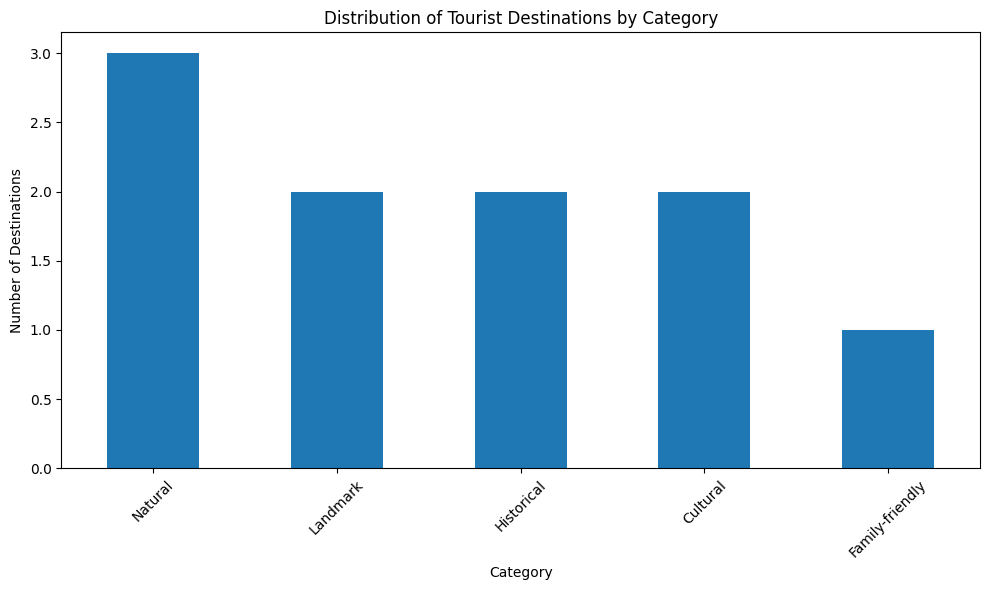

In [ ]:
# Plot the distribution of categories
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Tourist Destinations by Category')
plt.xlabel('Category')
plt.ylabel('Number of Destinations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

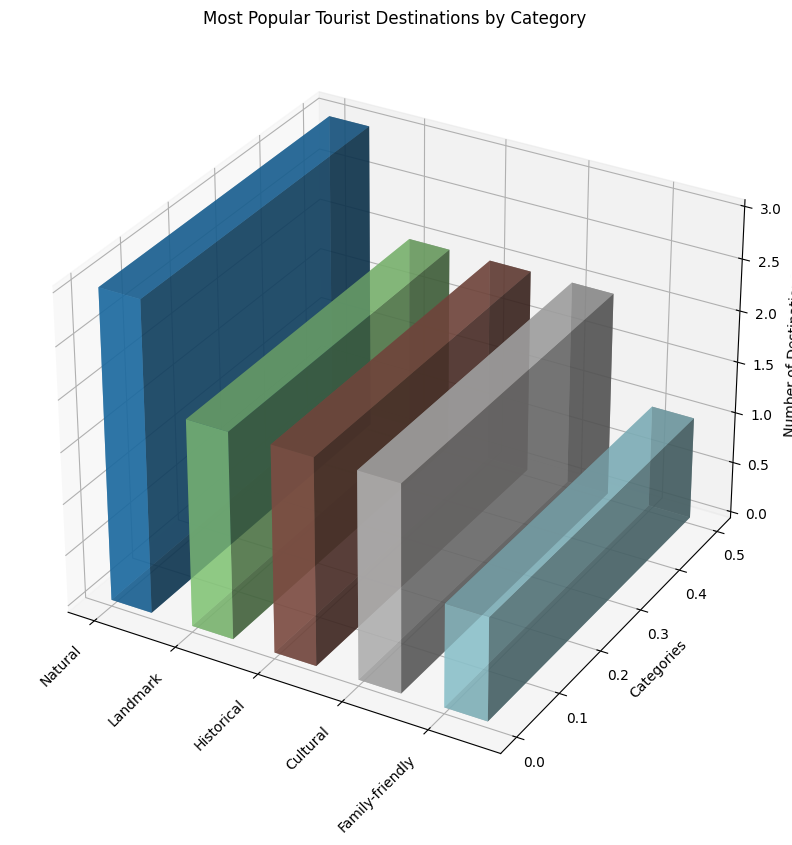

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your actual category_counts data)
categories = category_counts.index
counts = category_counts.values

# Create a 3D plot with a larger figure size
fig = plt.figure(figsize=(12, 8))  # Increase size
ax = fig.add_subplot(111, projection='3d')

# Set the position of bars on the x-axis
x = np.arange(len(categories))
y = np.zeros_like(x)  # All bars on the same y position
z = np.zeros_like(x)  # Base level for bars

# Set the height of the bars
dx = 0.5  # Width of the bars
dy = 0.5  # Depth of the bars
dz = counts  # Height of the bars

# Create a color map with the same number of colors as categories
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))

# Create bars
ax.bar3d(x, y, z, dx, dy, dz, color=colors, alpha=0.7)

# Set labels
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('Categories')
ax.set_zlabel('Number of Destinations')
ax.set_title('Most Popular Tourist Destinations by Category')

# Optionally disable tight_layout() if you prefer
# plt.tight_layout()
plt.show()